In [14]:
data_path = r"data\grand_finalle_data\no_yolo"


📊 **Dataset Statistics After step 0:**
  📂 Normal: 254 images
  📂 Osteopenia: 86 images
  📂 Osteoporosis: 220 images


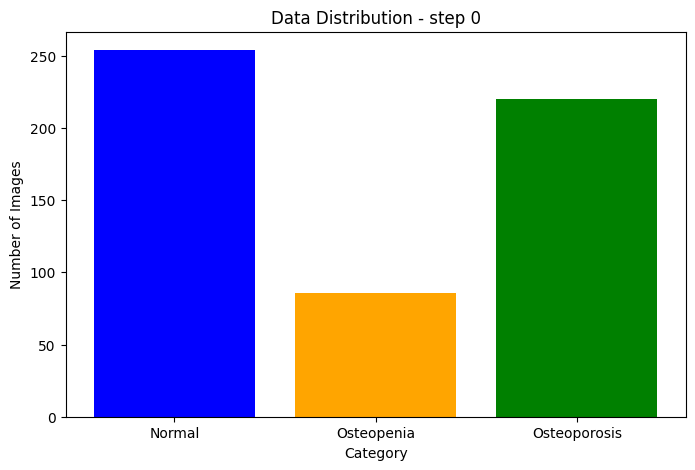

In [15]:
import os
from ultralytics import YOLO
from preprocessing.dedup import dedup_images_from_folder
from preprocessing.preprocess import dataset_statistics, crop_and_save_knees,show_yolo_performance
categories = ["Normal", "Osteopenia", "Osteoporosis"]
dataset_statistics(data_path, "step 0",categories)

WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading yolo\yolo_run\weights\best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider


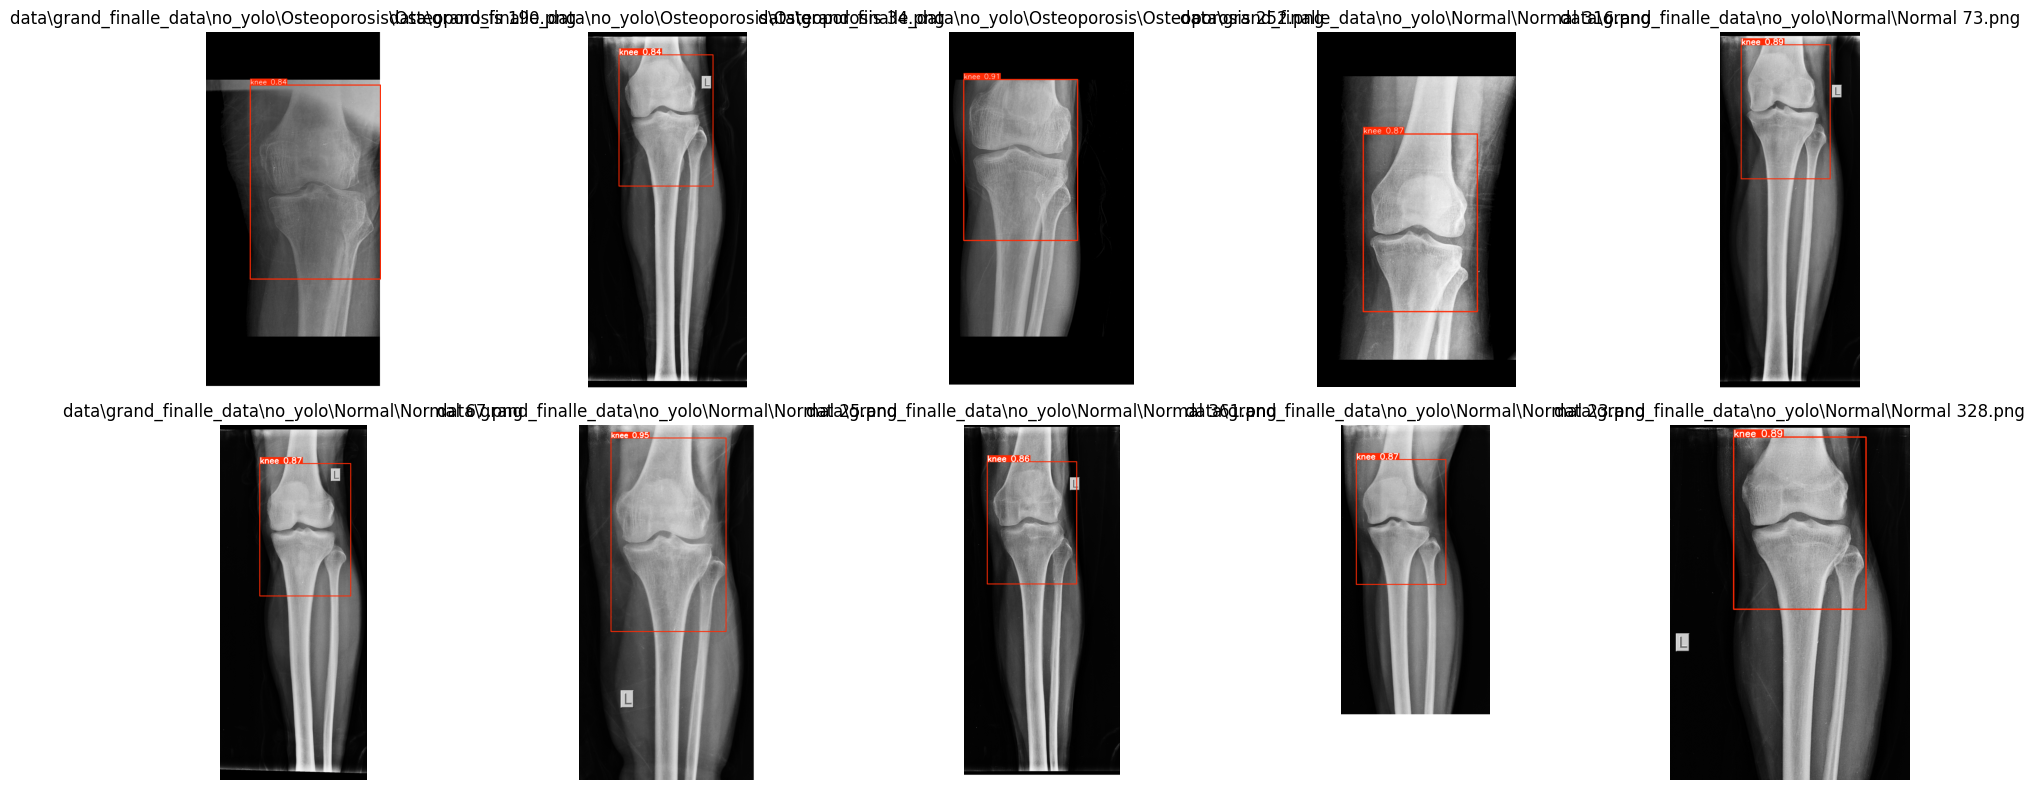

In [16]:

images_croped_by_yolo = os.path.join(data_path, r"cropped_by_yolo")
model_path = r"yolo\yolo_run\weights\best.onnx"
model = YOLO(model_path)

show_yolo_performance(data_path, model, categories)


In [19]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

def show_knee_statistics(input_path, model, categories):
    """
    Uses YOLO to detect knees and print statistics per class.
    Also creates a bar plot of 0/1/2 knees detected for each category.
    """
    image_extensions = ["jpg", "jpeg", "png", "bmp", "tiff"]
    stats = {cat: {"0_knees": 0, "1_knee": 0, "2_knees": 0} for cat in categories}

    for category in categories:
        category_path = os.path.join(input_path, category)

        # Collect all images for this category
        image_paths = []
        for ext in image_extensions:
            image_paths.extend(glob.glob(os.path.join(category_path, f"*.{ext}")))

        print(f"\n📂 Processing {category} - {len(image_paths)} images")

        for img_path in tqdm(image_paths, desc=f"Detecting knees in {category}"):
            image = cv2.imread(img_path)
            if image is None:
                print(f"⚠️ Skipping unreadable image: {img_path}")
                continue

            # Run YOLO detection
            results = model(image, verbose=False)

            detected_knees = []
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    detected_knees.append((x1, x2))

            width_threshold = image.shape[1] // 2
            left_detected = False
            right_detected = False

            # Determine which side each detected knee is on
            for x1, x2 in detected_knees:
                if x2 < width_threshold:
                    left_detected = True
                else:
                    right_detected = True

            # Count how many knees were found
            if left_detected and right_detected:
                stats[category]["2_knees"] += 1
            elif left_detected or right_detected:
                stats[category]["1_knee"] += 1
            else:
                stats[category]["0_knees"] += 1

        # Print summary for this category
        print(f"✅ {category} results:")
        print(f"   0 knees detected: {stats[category]['0_knees']}")
        print(f"   1 knee detected : {stats[category]['1_knee']}")
        print(f"   2 knees detected: {stats[category]['2_knees']}")

    # --- 📊 PLOT THE RESULTS ---
    labels = ["0 knees", "1 knee", "2 knees"]
    x = range(len(categories))
    
    zero_counts = [stats[cat]["0_knees"] for cat in categories]
    one_counts = [stats[cat]["1_knee"] for cat in categories]
    two_counts = [stats[cat]["2_knees"] for cat in categories]

    bar_width = 0.25
    plt.figure(figsize=(10, 6))

    plt.bar([i - bar_width for i in x], zero_counts, width=bar_width, label="0 knees", color="#FF6B6B")
    plt.bar(x, one_counts, width=bar_width, label="1 knee", color="#FFD93D")
    plt.bar([i + bar_width for i in x], two_counts, width=bar_width, label="2 knees", color="#6BCB77")

    plt.xticks(x, categories, fontsize=12)
    plt.ylabel("Number of Images", fontsize=14)
    plt.title("YOLO Knee Detection per Category", fontsize=16)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()



📂 Processing Normal - 254 images


Detecting knees in Normal: 100%|██████████| 254/254 [00:08<00:00, 31.60it/s]


✅ Normal results:
   0 knees detected: 0
   1 knee detected : 238
   2 knees detected: 16

📂 Processing Osteopenia - 86 images


Detecting knees in Osteopenia: 100%|██████████| 86/86 [00:06<00:00, 13.62it/s]


✅ Osteopenia results:
   0 knees detected: 0
   1 knee detected : 6
   2 knees detected: 80

📂 Processing Osteoporosis - 220 images


Detecting knees in Osteoporosis: 100%|██████████| 220/220 [00:05<00:00, 42.70it/s]

✅ Osteoporosis results:
   0 knees detected: 0
   1 knee detected : 198
   2 knees detected: 22


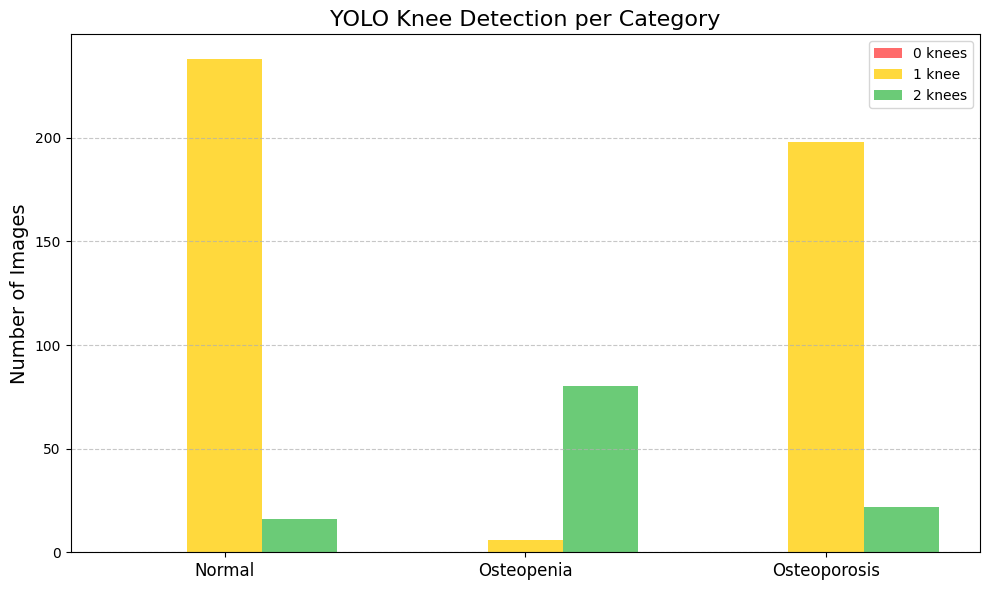

In [ ]:
show_knee_statistics(data_path, model,categories)

In [21]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

def analyze_images(input_path, categories):
    """
    Analyze resolution and file type for images in each category.
    Clusters resolution into 5 categories by total pixel count.
    Plots:
      1. File type distribution per category
      2. Resolution cluster distribution per category
    """

    image_extensions = ["jpg", "jpeg", "png", "bmp", "tiff"]
    all_stats = {}

    # Define resolution bins (in pixels)
    bins = [0, 256*256, 512*512, 1024*1024, 2048*2048, np.inf]
    bin_labels = ["XS (<256x256)", 
                  "S (256–512)", 
                  "M (512–1024)", 
                  "L (1024–2048)", 
                  "XL (>2048)"]

    for category in categories:
        category_path = os.path.join(input_path, category)
        image_paths = []
        for ext in image_extensions:
            image_paths.extend(glob.glob(os.path.join(category_path, f"*.{ext}")))

        file_types = []
        resolution_clusters = []

        for img_path in image_paths:
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            h, w = img.shape[:2]
            pixels = w * h

            # Determine which bin this resolution falls into
            bin_index = np.digitize(pixels, bins) - 1
            resolution_clusters.append(bin_labels[bin_index])

            # Track file type
            ext = os.path.splitext(img_path)[-1].lower().replace(".", "")
            file_types.append(ext)

        # Store data for this category
        all_stats[category] = {
            "file_types": Counter(file_types),
            "resolutions": Counter(resolution_clusters),
            "total_images": len(image_paths)
        }

    # --- 📊 FILE TYPE PLOT ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    file_type_df = pd.DataFrame({cat: stats["file_types"] for cat, stats in all_stats.items()}).fillna(0)
    file_type_df.T.plot(kind="bar", stacked=True, ax=axes[0],
                        color=["#FF6B6B", "#FFD93D", "#6BCB77", "#4D96FF", "#C77DFF"])
    axes[0].set_title("📁 File Type Distribution per Category", fontsize=14)
    axes[0].set_ylabel("Number of Images")
    axes[0].legend(title="File Type")
    axes[0].grid(axis="y", linestyle="--", alpha=0.5)

    # --- 📊 RESOLUTION CLUSTER PLOT ---
    resolution_df = pd.DataFrame({cat: stats["resolutions"] for cat, stats in all_stats.items()}).fillna(0)
    resolution_df = resolution_df.reindex(bin_labels)  # keep order XS -> XL

    resolution_df.T.plot(kind="bar", stacked=True, ax=axes[1],
                         color=["#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF"])
    axes[1].set_title("📏 Resolution Cluster Distribution per Category", fontsize=14)
    axes[1].set_ylabel("Number of Images")
    axes[1].legend(title="Resolution Cluster")
    axes[1].grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

    return all_stats


C:\Users\e0l07sq\AppData\Local\Temp\ipykernel_126776\4055931747.py:83: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\e0l07sq\AppData\Local\Temp\ipykernel_126776\4055931747.py:83: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\e0l07sq\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\e0l07sq\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


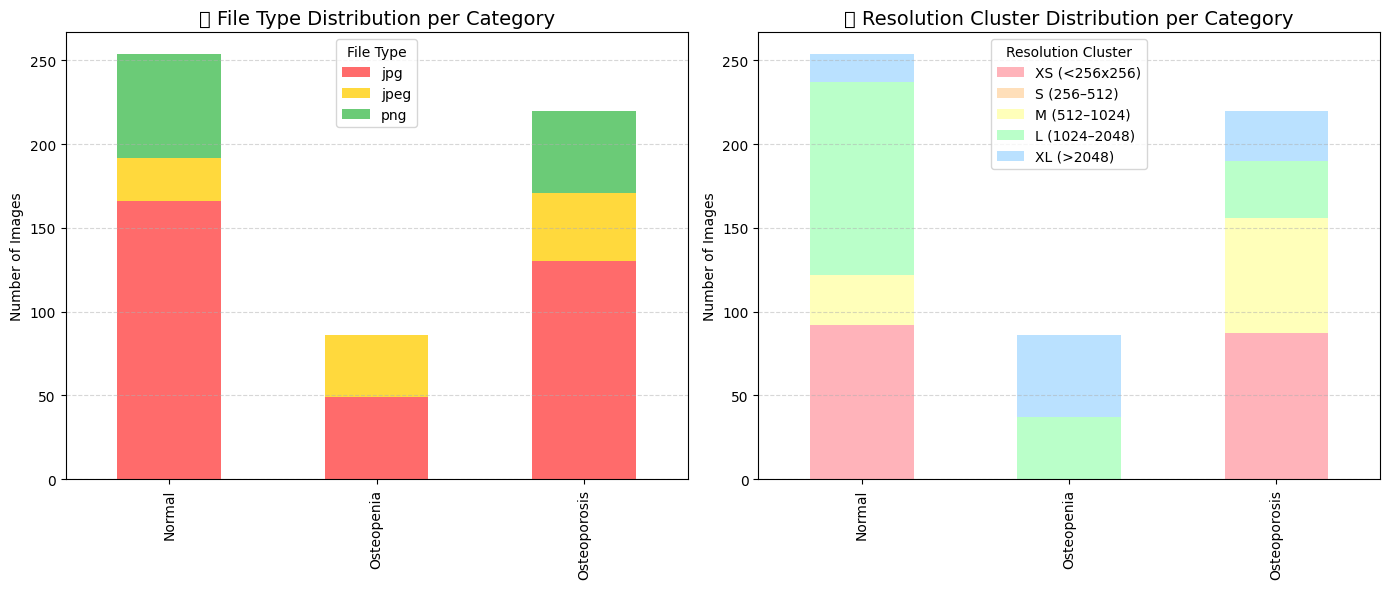

{'Normal': {'file_types': Counter({'jpg': 166, 'png': 62, 'jpeg': 26}),
  'resolutions': Counter({'L (1024–2048)': 115,
           'XS (<256x256)': 92,
           'M (512–1024)': 30,
           'XL (>2048)': 17}),
  'total_images': 254},
 'Osteopenia': {'file_types': Counter({'jpg': 49, 'jpeg': 37}),
  'resolutions': Counter({'XL (>2048)': 49, 'L (1024–2048)': 37}),
  'total_images': 86},
 'Osteoporosis': {'file_types': Counter({'jpg': 130, 'png': 49, 'jpeg': 41}),
  'resolutions': Counter({'XS (<256x256)': 87,
           'M (512–1024)': 69,
           'L (1024–2048)': 34,
           'XL (>2048)': 30}),
  'total_images': 220}}

In [22]:
analyze_images(data_path, categories)